International data taken from:
https://github.com/CSSEGISandData/COVID-19

In [1]:
%pylab inline
import pandas as pd
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
### Globals
x_tick_rot = 90
ms = 4

### Functions 
def sum_per_group(raw_groupby_df, group):
    df = raw_groupby_df.get_group(group)
    df = df.iloc[:, 4:]    
    df = df.loc[:,:].astype('int32')
    s = df.sum()
    vals = s.values
    x = df.columns

    return x, vals


def plot_group(raw_df, g, min_val=0, fig_title=''):
    if not isinstance(g, list):
        g = [g]

    raw_groupby_df = raw_df.fillna(0).groupby("Country/Region")

    title_grp = []

    for group in raw_groupby_df.groups:
        x, vals = sum_per_group(raw_groupby_df, group)

        if group in g and max(vals) >= min_val:
            plt.plot(x, vals, '-o', ms=ms, label='%s: %d' % (group, max(vals)))
            title_grp.append(group)

    plt.legend()
    plt.grid()
    _ = plt.xticks(rotation=x_tick_rot)
    plt.xlabel('Date')
    plt.ylabel('# People')
    plt.ylim(bottom=0)

    plt.title(fig_title)

    return title_grp

def plot_gradient_group(raw_df, g, min_val=0, fig_title='', sliding_win_size=11, polynomial_fit_degree=3):
    if not isinstance(g, list):
        g = [g]

    raw_groupby_df = raw_df.fillna(0).groupby("Country/Region")

    title_grp = []

    max_grad = 0

    for group in raw_groupby_df.groups:
        x, vals = sum_per_group(raw_groupby_df, group)
        grad = np.gradient(vals)
        grad_hat = savgol_filter(grad, sliding_win_size, polynomial_fit_degree) 

        if group in g and max(vals) >= min_val:
            #plot(x, grad, label='%s: Actual' % group)
            plt.plot(x, grad_hat,'-o', ms=ms, label='%s: Smoothed' % group)
            title_grp.append(group)

    plt.legend()
    plt.grid()
    _ = plt.xticks(rotation=90)
    plt.xlabel('Date')
    plt.ylabel('Derivative (people per day)')
    plt.ylim(bottom=0)

    plt.title(fig_title)


def plot_fatality_rate(raw_confirmed_df, raw_deaths_df, g, min_val=0, fig_title='', sliding_win_size=11, polynomial_fit_degree=3):
    if not isinstance(g, list):
        g = [g]

    raw_confirmed_groupby_df = raw_confirmed_df.fillna(0).groupby("Country/Region")
    raw_deaths_groupby_df = raw_deaths_df.fillna(0).groupby("Country/Region")

    title_grp = []

    for group in raw_confirmed_groupby_df.groups:
        x_c, vals_c = sum_per_group(raw_confirmed_groupby_df, group)
        x_d, vals_d = sum_per_group(raw_deaths_groupby_df, group)

        a = vals_d.astype(np.float32)
        b = vals_c.astype(np.float32)

        # Returns 0 if confirmed is 0
        ratio = np.divide(a, b, out=np.zeros_like(a), where=b!=0) 
        ratio_hat = savgol_filter(ratio, sliding_win_size, polynomial_fit_degree) 

        if group in g and max(ratio) >= min_val:
            #plot(x, grad, label='%s: Actual' % group)
            plt.plot(x_c, ratio_hat,'-o', ms=ms, label='%s: smoothed' % group)
            title_grp.append(group)

    plt.legend()
    plt.grid()
    plt._ = xticks(rotation=90)
    plt.xlabel('Date')
    plt.ylabel('Fatality rate')
    plt.ylim(0, 0.1)
    plt.title(fig_title)


def get_data_from_df(df):
    df = df.iloc[:, 4:].fillna(0)    
    df = df.loc[:,:].astype('int32')
    s = df.sum()
    vals = s.values
    x = df.columns
    
    return x, vals

In [3]:
# data from https://github.com/CSSEGISandData/2019-nCoV

raw_confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
raw_recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')
raw_death_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')

xc, confirmed_vals = get_data_from_df(raw_confirmed_df) 
xd, death_vals = get_data_from_df(raw_death_df)
xr, recovered_vals = get_data_from_df(raw_recovered_df)

xc = pd.to_datetime(xc)
xd = pd.to_datetime(xd)
xr = pd.to_datetime(xr)

# Parameters for savgol filter (Smooting curves)
sliding_win_size = 15
polynomial_fit_degree = 3

In [4]:
def get_xdata(x):
    return ['%02d-%02d' % (i.date().month, i.date().day) for i in x.to_list()]

### Global Statistics 

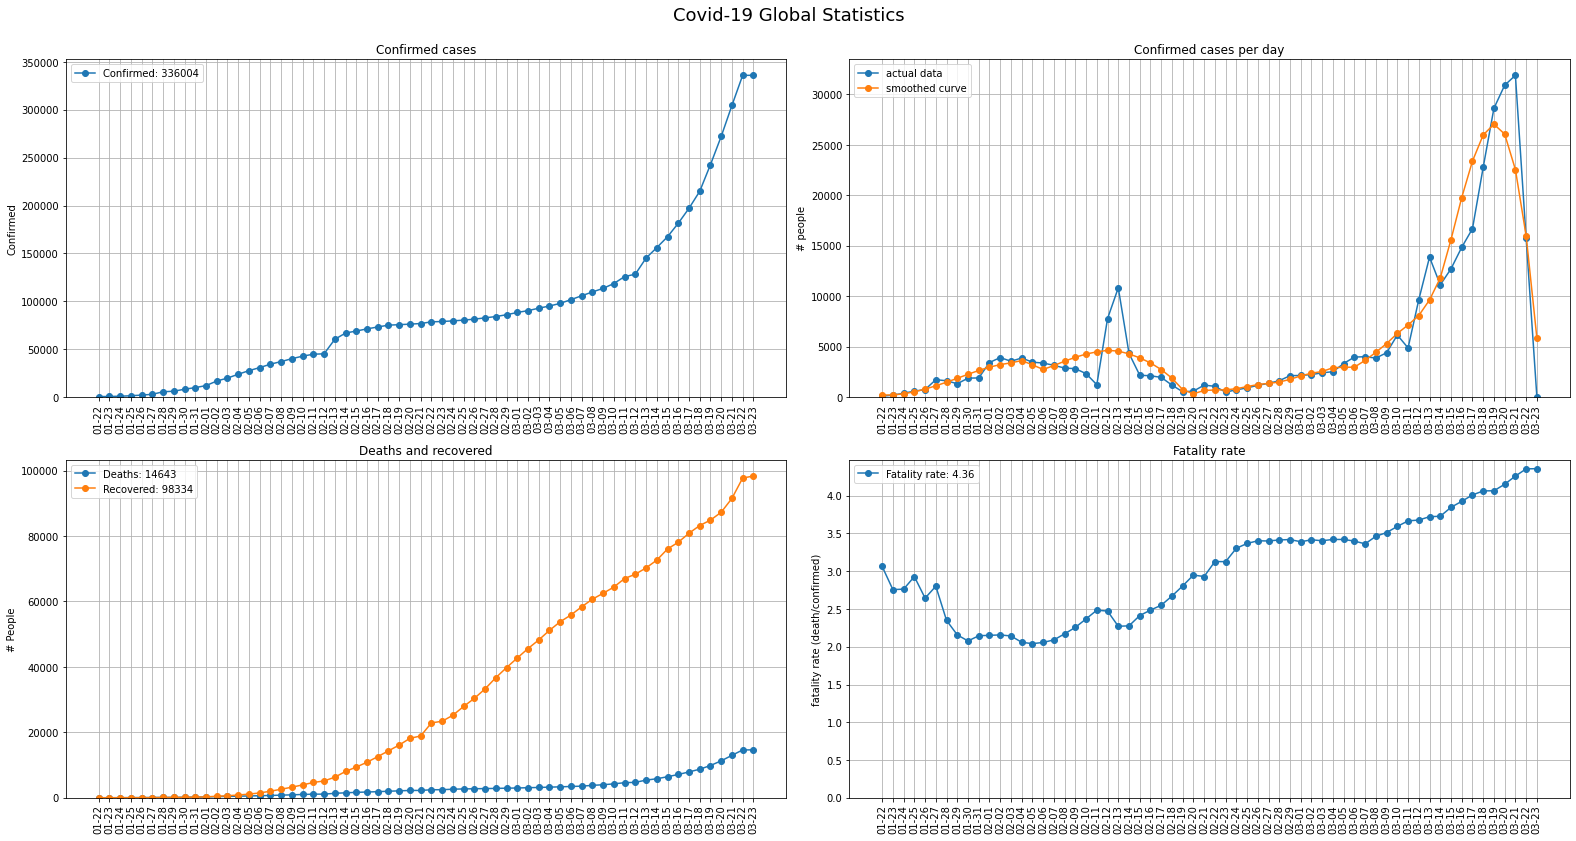

In [5]:
death_vals_hat = savgol_filter(death_vals, sliding_win_size, polynomial_fit_degree) # window size, polynomial order 
recovered_vals_hat = savgol_filter(recovered_vals, sliding_win_size, polynomial_fit_degree) # window size, polynomial order

fig = plt.figure(figsize=(22,12))

ax = plt.subplot(2,2,1)
plt.plot(get_xdata(xc), confirmed_vals, '-o', label='Confirmed: %d' % confirmed_vals[-1])
plt.ylabel("Confirmed")
plt.ylim(bottom=0)
plt.title('Confirmed cases')
plt.grid()
plt.legend()
_ = plt.xticks(rotation=x_tick_rot)

plt.subplot(2,2,2)
confirmed_grad = np.gradient(confirmed_vals)
confirmed_grad_hat = savgol_filter(confirmed_grad, sliding_win_size, polynomial_fit_degree) 

plt.plot(get_xdata(xc), confirmed_grad, '-o', label='actual data')
plt.plot(get_xdata(xc), confirmed_grad_hat, '-o', label='smoothed curve')
plt.ylabel("# people")
plt.ylim(bottom=0)
plt.title('Confirmed cases per day')
plt.grid()
plt.legend()
_ = plt.xticks(rotation=x_tick_rot)

subplot(2,2,3)
plt.plot(get_xdata(xd), death_vals, '-o', label='Deaths: %d' % death_vals[-1])
plt.plot(get_xdata(xr), recovered_vals, '-o', label='Recovered: %d' % recovered_vals[-1])
_ = plt.xticks(rotation=x_tick_rot)
plt.ylabel('# People')
plt.ylim(bottom=0)
plt.title('Deaths and recovered')
plt.grid()
plt.legend()

subplot(2,2,4)
x_ratio = []
ratio_vals = []
for i, x in enumerate(xd):
    if x in xr:
        ir = xr.get_loc(x)
        x_ratio.append(x)
        ratio_vals.append(death_vals[i] / (confirmed_vals[i])* 100)
plt.plot(get_xdata(xd), ratio_vals, '-o', label='Fatality rate: %.2f' % ratio_vals[-1])
plt.ylabel("fatality rate (death/confirmed)")
plt.ylim(bottom=0)
plt.legend()

plt.title('Fatality rate')
plt.grid()
_ = plt.xticks(rotation=x_tick_rot)

plt.tight_layout(rect=[0, 0.01, 1, 0.95])
plt.suptitle("Covid-19 Global Statistics", fontsize=18)

fig.savefig('figures/global_resume.png', dpi=300, transparency=False, bbox_inches='tight')

### Per Nation Plots

In [6]:
min_val = 5000 # Set here the minimum number of total case a nation must have to plot its data

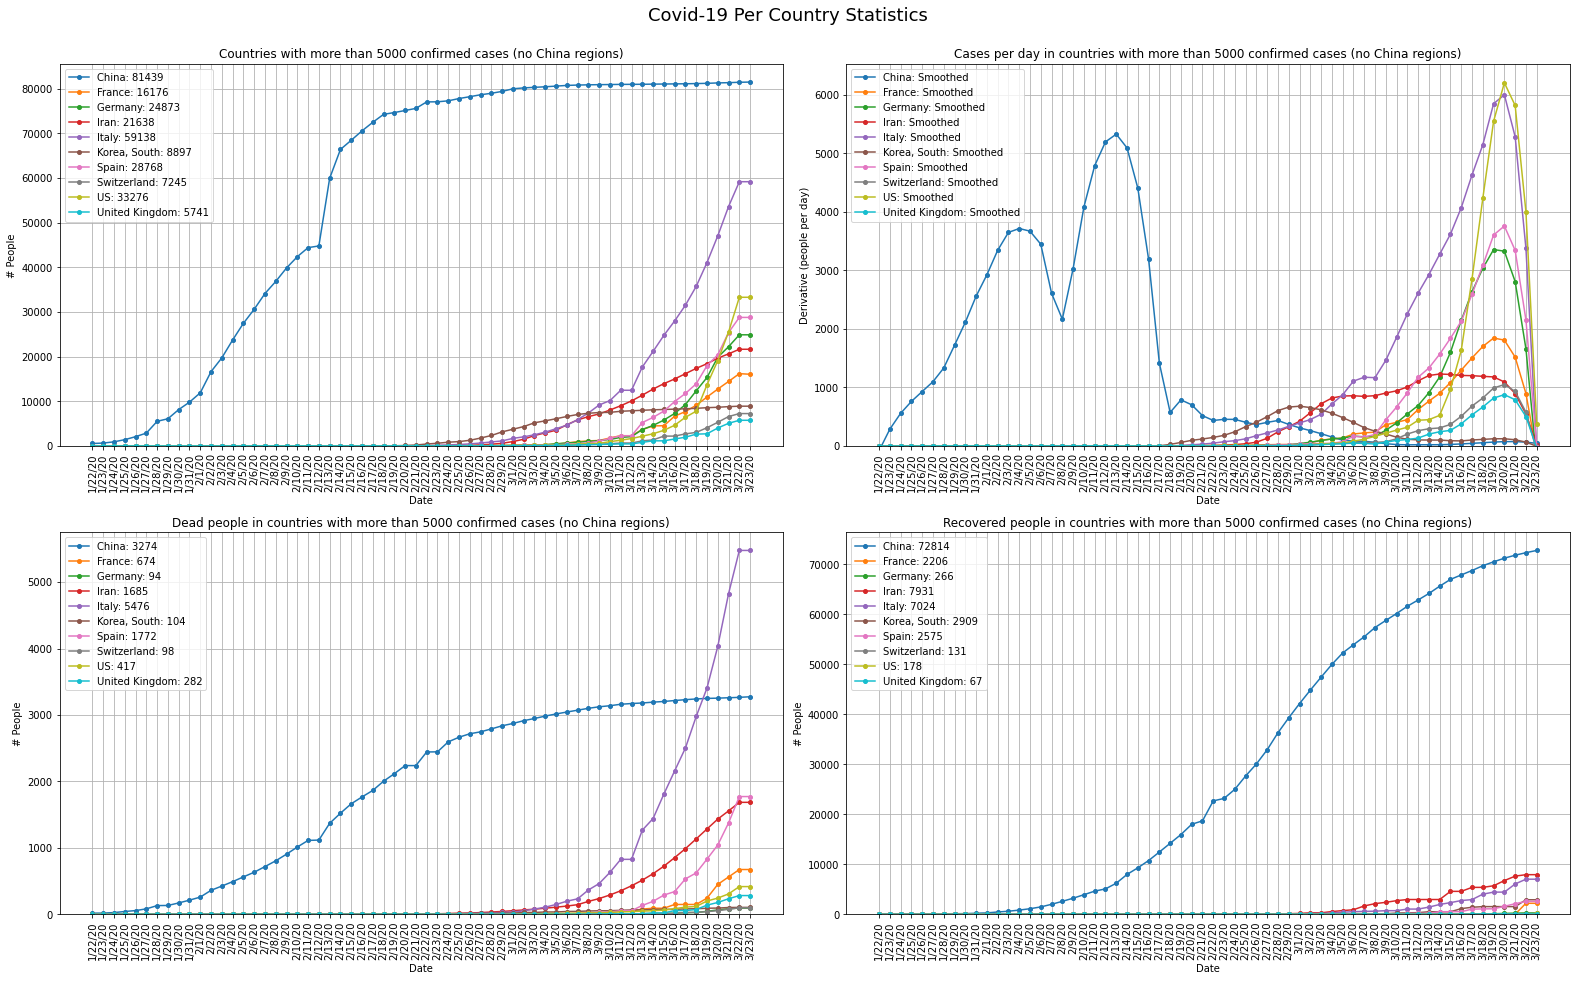

In [7]:
## Nation with confirmed cases larger than 200 people
grps = raw_confirmed_df.fillna(0).groupby("Country/Region").groups.keys()
g = [i for i in grps]

fig=figure(figsize=(22,14))
subplot(2,2,1)
countries = plot_group(raw_confirmed_df, g, min_val=min_val, fig_title='Countries with more than %d confirmed cases (no China regions)' % min_val)

subplot(2,2,2)
plot_gradient_group(raw_confirmed_df, g, min_val= min_val, fig_title='Cases per day in countries with more than %d confirmed cases (no China regions)' % min_val)

subplot(2,2,3)
# Deaths of previously analyzed countries
plot_group(raw_death_df, g = countries, fig_title='Dead people in countries with more than %d confirmed cases (no China regions)' % min_val)

subplot(2,2,4)
# Recovered  of previously analyzed countries
plot_group(raw_recovered_df, g = countries, fig_title='Recovered people in countries with more than %d confirmed cases (no China regions)' % min_val)


plt.tight_layout(rect=[0, 0.01, 1, 0.95])
plt.suptitle("Covid-19 Per Country Statistics", fontsize=18)

fig.savefig('figures/countries_resume.png', dpi=300, transparency=False, bbox_inches='tight')